In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from models import VAE, Encoder, Decoder
from training_functions import train_vae
from helper_functions import Evaluator, visualize_reconstructions, generate_images

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda


## Wczytanie danych

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
dataset_path = "./trafic_32"
dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

labels = dataset.classes
print("Number of labels:", len(dataset.classes))

Number of labels: 43


In [3]:
train_ratio = 0.8

train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

train, val = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train, batch_size=4, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val, batch_size=4, shuffle=True, num_workers=4)

In [12]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Image size: torch.Size([3, 32, 32])


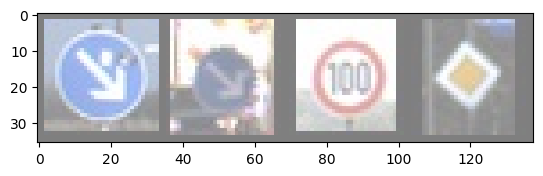

In [13]:
train_batch, train_labels = next(iter(train_loader))
print(f"Image size: {train_batch[0].shape}")
imshow(torchvision.utils.make_grid(train_batch))

## Ewaluacja

In [ ]:
image_dim = 32*32*3
evaluator = Evaluator(image_dim, 256, n_classes=len(labels)).to(device)
# Optimizers
optimizer = torch.optim.Adam(evaluator.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.97)

# loss
criterion = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 7
for epoch in range(num_epochs):
    for data, targets in iter(data_loader):
        data = data.to(device)
        targets = targets.to(device)
        targets = torch.nn.functional.one_hot(targets, num_classes=len(labels)).float()
        _, targets = torch.max(targets, dim=1)

        results = evaluator(data)
        loss = criterion(results, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
num_correct = 0
total_guesses = 0

evaluator.eval()
with torch.no_grad():
    for data, targets in iter(val_loader):
        # Sends data and targets to device
        data = data.to(device)
        targets = targets.to(device)

        # Acquires the network's best guesses at each class
        results = evaluator(data)
        best_guesses = torch.argmax(results, 1)

        # Updates number of correct and total guesses
        num_correct += torch.eq(targets, best_guesses).sum().item()
        total_guesses += len(targets)

print("Correctly guessed ", num_correct/total_guesses*100, "% of the dataset")

Correctly guessed  93.99387911247132 % of the dataset


In [ ]:
torch.save(evaluator.state_dict(), "evaluator.pth")

## Podstawowy model

In [5]:
image_dim = 32*32*3
encoder = Encoder(image_dim, hidden_dim=256, latent_dim=32)
decoder = Decoder(latent_dim=32, hidden_dim=256, output_dim=image_dim, image_shape=[3, 32, 32])
vae = VAE(encoder, decoder)

### Trenowanie

In [5]:
def vae_loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD      = -0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [6]:
evaluator = Evaluator(image_dim, 256, n_classes=len(labels)).to(device)
evaluator.load_state_dict(torch.load("evaluator.pth"))

<All keys matched successfully>

In [7]:
optimizer = optim.Adam(vae.parameters(), lr=0.001)
val_loader = torch.utils.data.DataLoader(val, batch_size=len(val), shuffle=True, num_workers=4)
val_set = next(iter(val_loader))
loss_hist, eval_hist = train_vae(vae, train_loader, val_set[0], optimizer, vae_loss_function, evaluator.evaluate, epochs=10)

100%|██████████| 10/10 [04:45<00:00, 28.56s/it]


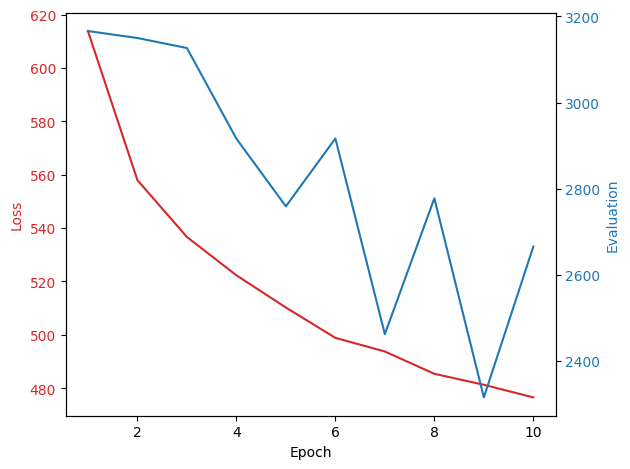

In [8]:
fig, ax1 = plt.subplots()
iters = np.arange(1, 11)
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(iters, loss_hist, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Evaluation', color=color)
ax2.plot(iters, eval_hist, color=color, linestyle='solid', label='Validation')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

In [9]:
torch.save(vae.encoder.state_dict(), "vae_encoder.pth")
torch.save(vae.decoder.state_dict(), "vae_decoder.pth")

### Ewaluacja

In [8]:
encoder = Encoder(image_dim, hidden_dim=256, latent_dim=32)
decoder = Decoder(latent_dim=32, hidden_dim=256, output_dim=image_dim, image_shape=[3, 32, 32])
encoder.load_state_dict(torch.load("vae_encoder.pth"))
decoder.load_state_dict(torch.load("vae_decoder.pth"))
vae = VAE(encoder, decoder).to(device)
val_loader = torch.utils.data.DataLoader(val, batch_size=len(val), shuffle=True, num_workers=4)
val_set = next(iter(val_loader))

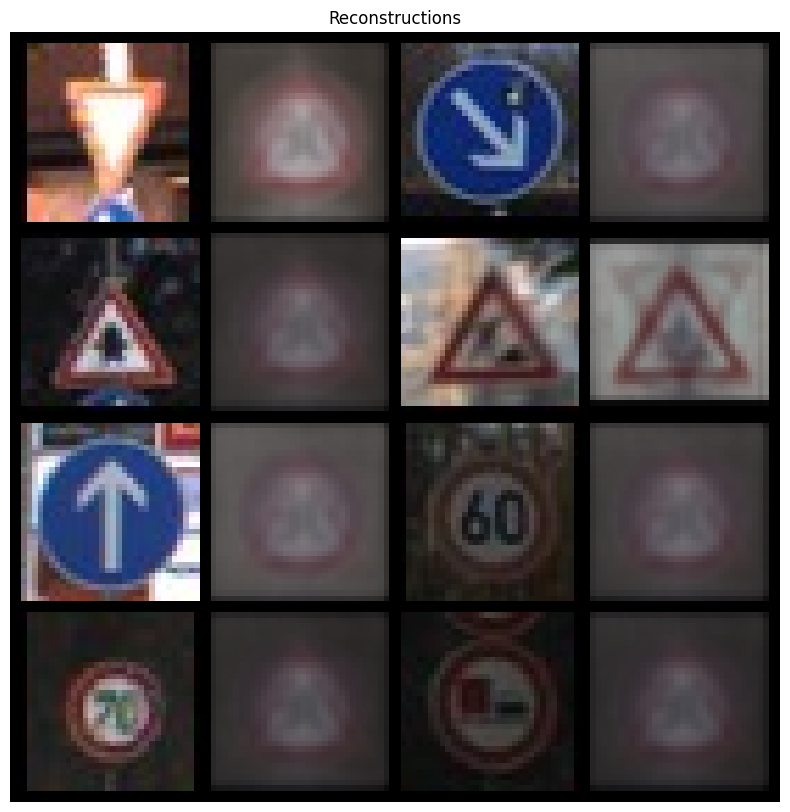

In [9]:
visualize_reconstructions(vae, val_set[0][:8], device)

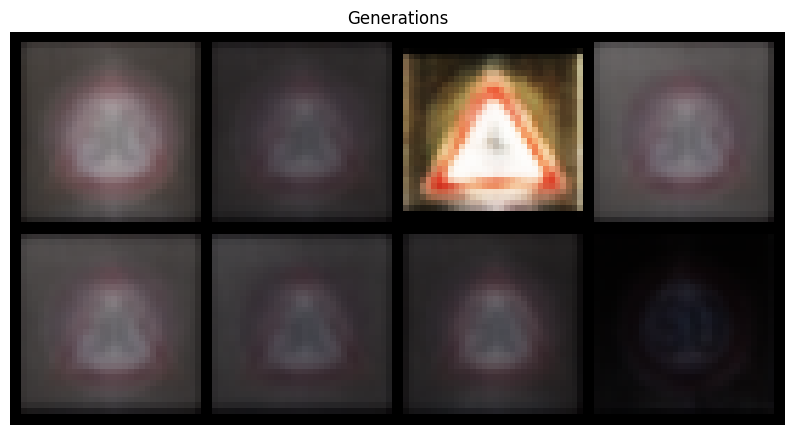

In [10]:
generate_images(vae.decoder, 8, device)

## Dodanie Warstw konwolucyjnych

In [6]:
from models import ConvDecoder, ConvEncoder

In [5]:
def vae_loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD      = -0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [6]:
image_dim = 32*32*3
encoder = ConvEncoder(image_dim, hidden_dim=256, latent_dim=32, image_shape=[3, 32, 32])
decoder = ConvDecoder(latent_dim=32, hidden_dim=256, output_dim=image_dim, image_shape=[3, 32, 32])
conv_vae = VAE(encoder, decoder)

In [7]:
evaluator = Evaluator(image_dim, 256, n_classes=len(labels)).to(device)
evaluator.load_state_dict(torch.load("evaluator.pth"))

<All keys matched successfully>

In [8]:
optimizer = optim.Adam(conv_vae.parameters(), lr=0.001)
val_loader = torch.utils.data.DataLoader(val, batch_size=len(val), shuffle=True, num_workers=4)
val_set = next(iter(val_loader))
loss_hist, eval_hist = train_vae(conv_vae, train_loader, val_set[0], optimizer, vae_loss_function, evaluator.evaluate, epochs=10)

100%|██████████| 10/10 [05:33<00:00, 33.31s/it]


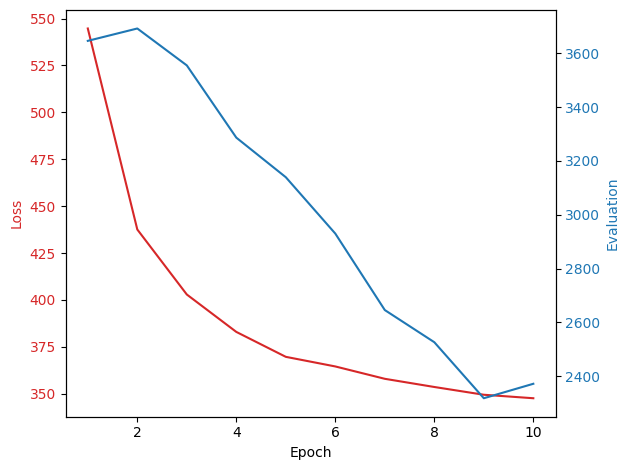

In [9]:
fig, ax1 = plt.subplots()
iters = np.arange(1, 11)
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(iters, loss_hist, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Evaluation', color=color)
ax2.plot(iters, eval_hist, color=color, linestyle='solid', label='Validation')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

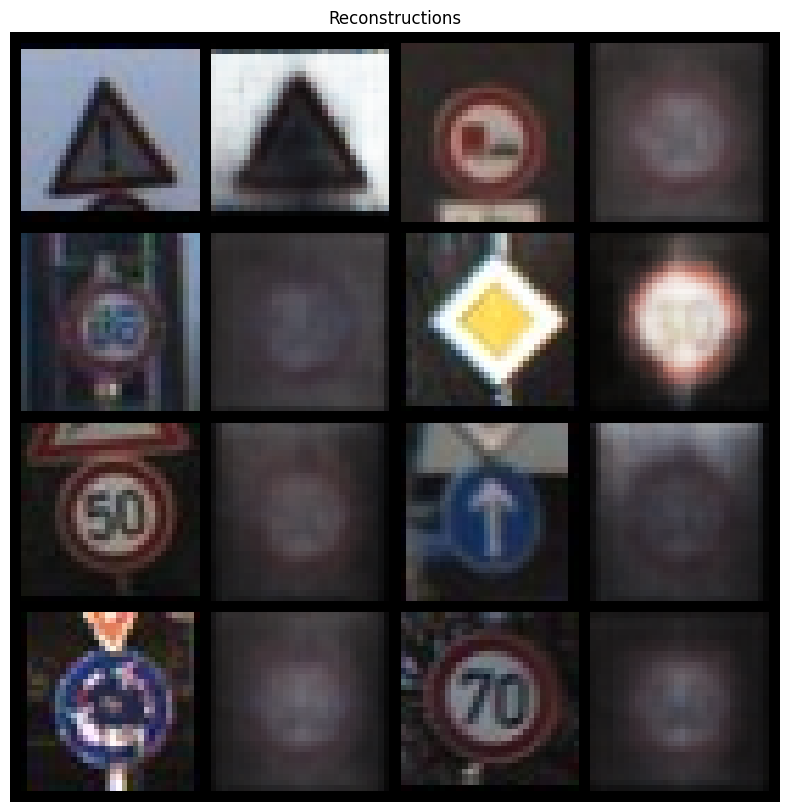

In [10]:
visualize_reconstructions(conv_vae, val_set[0][:8], device)

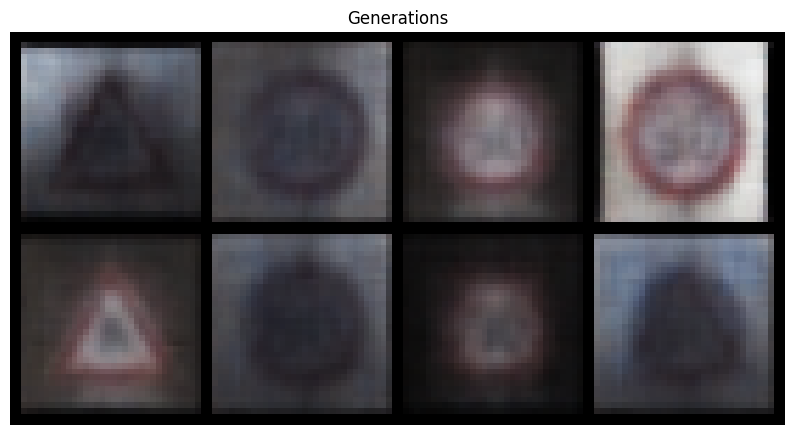

In [11]:
generate_images(conv_vae.decoder, 8, device)

In [19]:
torch.save(conv_vae.encoder.state_dict(), "conv_vae_encoder.pth")
torch.save(conv_vae.decoder.state_dict(), "conv_vae_decoder.pth")

## $\beta$-VAE

In [4]:
def beta_vae_loss_function(x, x_hat, mean, log_var, beta=1):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD      = -0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + beta * KLD

In [7]:
image_dim = 32*32*3
encoder = ConvEncoder(image_dim, hidden_dim=256, latent_dim=32, image_shape=[3, 32, 32])
decoder = ConvDecoder(latent_dim=32, hidden_dim=256, output_dim=image_dim, image_shape=[3, 32, 32])
beta_vae = VAE(encoder, decoder)

In [8]:
evaluator = Evaluator(image_dim, 256, n_classes=len(labels)).to(device)
evaluator.load_state_dict(torch.load("evaluator.pth"))

<All keys matched successfully>

In [11]:
optimizer = optim.Adam(beta_vae.parameters(), lr=0.001)
val_loader = torch.utils.data.DataLoader(val, batch_size=len(val), shuffle=True, num_workers=4)
val_set = next(iter(val_loader))

def five_beta(x, x_hat, mean, log_var):
    return beta_vae_loss_function(x, x_hat, mean, log_var, beta=5)

def ten_beta(x, x_hat, mean, log_var):
    return beta_vae_loss_function(x, x_hat, mean, log_var, beta=10)


loss_hist, eval_hist = train_vae(beta_vae, train_loader, val_set[0], optimizer, five_beta, evaluator.evaluate, epochs=10)

100%|██████████| 10/10 [05:58<00:00, 35.82s/it]


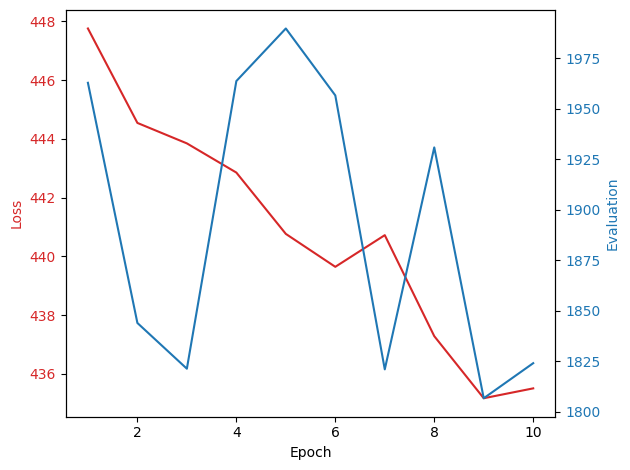

In [12]:
fig, ax1 = plt.subplots()
iters = np.arange(1, 11)
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(iters, loss_hist, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Evaluation', color=color)
ax2.plot(iters, eval_hist, color=color, linestyle='solid', label='Validation')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

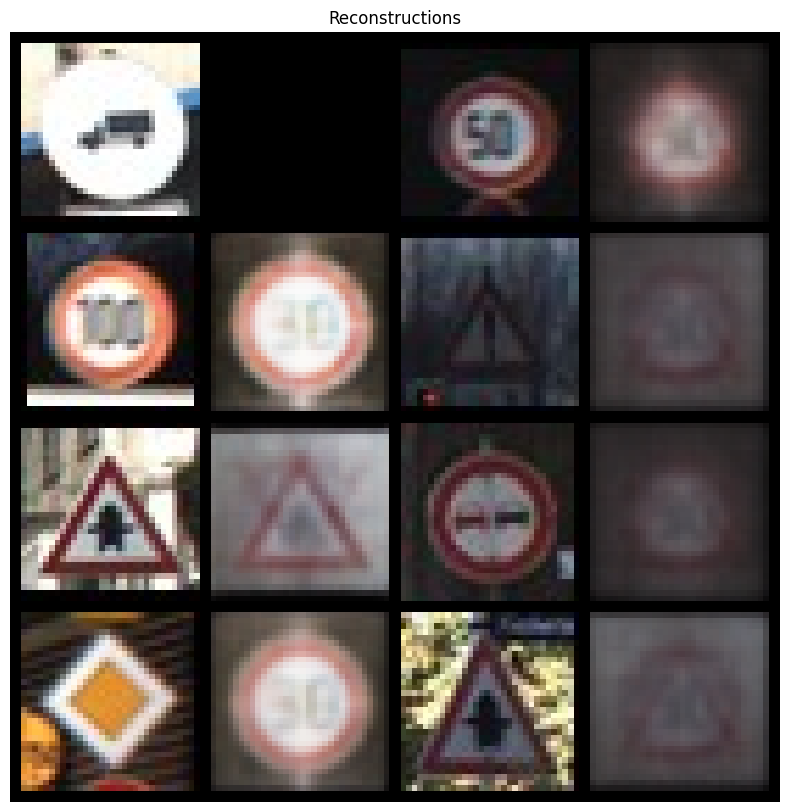

In [13]:
visualize_reconstructions(beta_vae, val_set[0][:8], device)

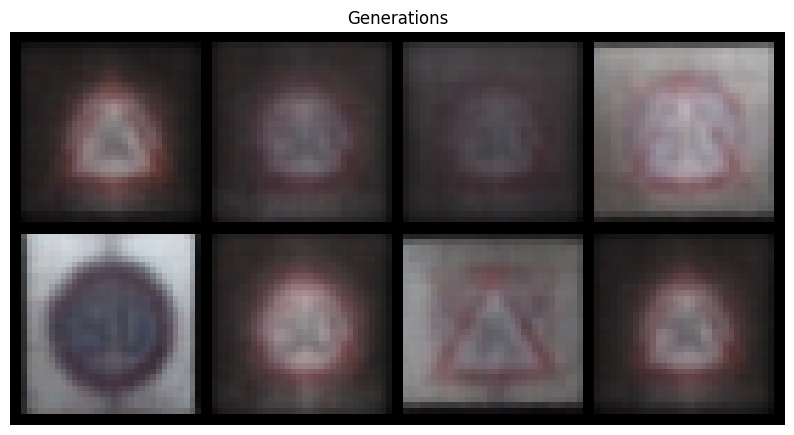

In [14]:
generate_images(beta_vae.decoder, 8, device)

In [15]:
torch.save(beta_vae.encoder.state_dict(), "beta_vae_encoder.pth")
torch.save(beta_vae.decoder.state_dict(), "beta_vae_decoder.pth")